In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, Input, layers, optimizers, regularizers, callbacks, losses, metrics 
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# FOR KAGGLE
train_images_dir = '../input/petfinder-pawpularity-score/train/'
test_images_dir = '../input/petfinder-pawpularity-score/test/'

# FOR LOCAL PC
# train_images_dir = './dataset/train/'
# test_images_dir = './dataset/test/'

In [4]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train_df.loc[:, 'filename'] = train_images_dir + train_df['Id'] + '.jpg'

test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df.loc[:, 'filename'] = test_images_dir + test_df['Id'] + '.jpg'

In [5]:
train_df.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,filename
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_df.loc[:, train_df.columns != 'Pawpularity'], train_df['Pawpularity'], test_size=0.2, random_state=42)

In [7]:
cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

In [8]:
img_size = (320, 320, 3)
BATCH_SIZE = 32

def augment_image(inputs, label=None):
    image = tf.image.random_flip_left_right(inputs[0])
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_hue(image, 0.05)
    return (image, inputs[1]), label

def parse_image(inputs, label=None):
    image_string = tf.io.read_file(inputs[0])
    image = tf.image.decode_jpeg(image_string, channels=img_size[2])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, img_size[:2])
    return (image, inputs[1]), label

def get_dataset(inputs, label=None, shuffle=False, augment=False, repeat=False):
    dataset = tf.data.TFRecordDataset.from_tensor_slices((inputs, label))     
    dataset = dataset.map(parse_image, num_parallel_calls=4)
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=4)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(True)
    return dataset

In [9]:
train_dataset = get_dataset((X_train['filename'], X_train[cols]), y_train, shuffle=True, augment=True)
val_dataset = get_dataset((X_val['filename'], X_val[cols]), y_val)
test_dataset = get_dataset((test_df['filename'], test_df[cols]))

2021-12-19 19:46:14.909363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:46:15.057087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:46:15.058093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 19:46:15.062145: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
# inputs
image_input = Input(shape=img_size)
tabular_input = Input(shape=(len(cols),))

# image processing
x = layers.Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(image_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(image_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.2)(x)
flat_img = layers.Flatten()(x)

# tabular metadata processing
y = layers.Dense(128, activation='relu')(tabular_input)
y = layers.Dropout(0.3)(y)
y = layers.Dense(64, activation='relu')(y)
y = layers.Dropout(0.3)(y)

# combining
z = layers.Concatenate(name='concat')([flat_img, y])
z = layers.Dense(32, activation='relu')(z)
z = layers.Dropout(0.3)(z)
z = layers.Dense(16, activation='relu')(z)
output = layers.Dense(1)(z)
# output = layers.Rescaling(100)(z)

model = tf.keras.Model(
    inputs = (image_input, tabular_input),
    outputs=output
)
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.MeanSquaredError(), 
              metrics=[metrics.RootMeanSquaredError()]
             )

In [11]:
es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.002, patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.000001)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
#     steps_per_epoch=20,
#     use_multiprocessing=True,
#     callbacks=[es, reduce_lr]
)

Epoch 1/100


2021-12-19 19:46:19.215724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 19:46:29.417381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 706 of 1024
2021-12-19 19:46:33.589395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-19 19:46:35.929999: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


248/248 [==============================] - 140s 475ms/step - loss: 3676.4644 - root_mean_squared_error: 60.6339 - val_loss: 222105.2812 - val_root_mean_squared_error: 471.2805
Epoch 2/100


2021-12-19 19:48:51.311873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 981 of 1024
2021-12-19 19:48:51.720114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 114s 416ms/step - loss: 647.5301 - root_mean_squared_error: 25.4466 - val_loss: 53707.6328 - val_root_mean_squared_error: 231.7491
Epoch 3/100


2021-12-19 19:50:44.952956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 888 of 1024
2021-12-19 19:50:46.583321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 113s 409ms/step - loss: 622.8256 - root_mean_squared_error: 24.9565 - val_loss: 5385.8677 - val_root_mean_squared_error: 73.3885
Epoch 4/100


2021-12-19 19:52:38.074509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 790 of 1024
2021-12-19 19:52:40.602154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 425ms/step - loss: 598.3295 - root_mean_squared_error: 24.4608 - val_loss: 2681.9363 - val_root_mean_squared_error: 51.7874
Epoch 5/100


2021-12-19 19:54:36.090620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 889 of 1024
2021-12-19 19:54:37.900212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 428ms/step - loss: 583.9186 - root_mean_squared_error: 24.1644 - val_loss: 1179.9911 - val_root_mean_squared_error: 34.3510
Epoch 6/100


2021-12-19 19:56:58.013261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 824 of 1024
2021-12-19 19:57:00.939586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 423ms/step - loss: 570.5922 - root_mean_squared_error: 23.8871 - val_loss: 834.3076 - val_root_mean_squared_error: 28.8844
Epoch 7/100


2021-12-19 19:58:55.983459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 846 of 1024
2021-12-19 19:58:57.939230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 120s 437ms/step - loss: 544.8858 - root_mean_squared_error: 23.3428 - val_loss: 5874.6880 - val_root_mean_squared_error: 76.6465
Epoch 8/100


2021-12-19 20:00:56.396717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 886 of 1024
2021-12-19 20:00:58.505593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 432ms/step - loss: 555.1519 - root_mean_squared_error: 23.5617 - val_loss: 1666.9415 - val_root_mean_squared_error: 40.8282
Epoch 9/100


2021-12-19 20:03:18.333439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 888 of 1024
2021-12-19 20:03:20.490158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 440ms/step - loss: 551.3516 - root_mean_squared_error: 23.4809 - val_loss: 480.7620 - val_root_mean_squared_error: 21.9263
Epoch 10/100


2021-12-19 20:05:40.287218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 814 of 1024
2021-12-19 20:05:43.291407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 435ms/step - loss: 566.4210 - root_mean_squared_error: 23.7996 - val_loss: 1066.1084 - val_root_mean_squared_error: 32.6513
Epoch 11/100


2021-12-19 20:07:41.332240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 800 of 1024
2021-12-19 20:07:43.828512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 440ms/step - loss: 562.3611 - root_mean_squared_error: 23.7142 - val_loss: 1284.9835 - val_root_mean_squared_error: 35.8467
Epoch 12/100


2021-12-19 20:10:03.285666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 752 of 1024
2021-12-19 20:10:06.312729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 436ms/step - loss: 575.7338 - root_mean_squared_error: 23.9945 - val_loss: 736.2664 - val_root_mean_squared_error: 27.1342
Epoch 13/100


2021-12-19 20:12:25.200881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 817 of 1024
2021-12-19 20:12:27.437642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 419ms/step - loss: 565.0386 - root_mean_squared_error: 23.7705 - val_loss: 1942.1941 - val_root_mean_squared_error: 44.0703
Epoch 14/100


2021-12-19 20:14:21.417215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 890 of 1024
2021-12-19 20:14:22.874740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 120s 437ms/step - loss: 569.1096 - root_mean_squared_error: 23.8560 - val_loss: 13915.1104 - val_root_mean_squared_error: 117.9623
Epoch 15/100


2021-12-19 20:16:21.470071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 762 of 1024
2021-12-19 20:16:24.749823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 123s 442ms/step - loss: 565.7284 - root_mean_squared_error: 23.7850 - val_loss: 560.1022 - val_root_mean_squared_error: 23.6665
Epoch 16/100


2021-12-19 20:18:24.483169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 847 of 1024
2021-12-19 20:18:26.758781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 441ms/step - loss: 539.5166 - root_mean_squared_error: 23.2275 - val_loss: 454.2786 - val_root_mean_squared_error: 21.3138
Epoch 17/100


2021-12-19 20:20:46.424644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 866 of 1024
2021-12-19 20:20:48.396115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 120s 437ms/step - loss: 8592.7168 - root_mean_squared_error: 92.6969 - val_loss: 861.9092 - val_root_mean_squared_error: 29.3583
Epoch 18/100


2021-12-19 20:23:08.390057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 901 of 1024
2021-12-19 20:23:09.730516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 432ms/step - loss: 637.6381 - root_mean_squared_error: 25.2515 - val_loss: 623.4969 - val_root_mean_squared_error: 24.9699
Epoch 19/100


2021-12-19 20:25:07.152657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 781 of 1024
2021-12-19 20:25:09.793852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 436ms/step - loss: 580.4506 - root_mean_squared_error: 24.0925 - val_loss: 3401.9426 - val_root_mean_squared_error: 58.3262
Epoch 20/100


2021-12-19 20:27:08.024094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 839 of 1024
2021-12-19 20:27:10.013637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 120s 436ms/step - loss: 553.2042 - root_mean_squared_error: 23.5203 - val_loss: 527.6916 - val_root_mean_squared_error: 22.9715
Epoch 21/100


2021-12-19 20:29:08.245913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 759 of 1024
2021-12-19 20:29:11.132863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 123s 444ms/step - loss: 535.7000 - root_mean_squared_error: 23.1452 - val_loss: 443.7225 - val_root_mean_squared_error: 21.0647
Epoch 22/100


2021-12-19 20:31:30.139357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 678 of 1024
2021-12-19 20:31:33.906715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 123s 439ms/step - loss: 526.5881 - root_mean_squared_error: 22.9475 - val_loss: 500.3700 - val_root_mean_squared_error: 22.3690
Epoch 23/100


2021-12-19 20:33:52.047672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 735 of 1024
2021-12-19 20:33:55.216411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 434ms/step - loss: 517.7637 - root_mean_squared_error: 22.7544 - val_loss: 444.3058 - val_root_mean_squared_error: 21.0786
Epoch 24/100


2021-12-19 20:36:13.962751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 892 of 1024
2021-12-19 20:36:15.355931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 444ms/step - loss: 512.2452 - root_mean_squared_error: 22.6328 - val_loss: 1153.2412 - val_root_mean_squared_error: 33.9594
Epoch 25/100


2021-12-19 20:38:15.649265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 752 of 1024
2021-12-19 20:38:18.601307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 117s 418ms/step - loss: 507.2021 - root_mean_squared_error: 22.5211 - val_loss: 713.3060 - val_root_mean_squared_error: 26.7078
Epoch 26/100


2021-12-19 20:40:12.444246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 736 of 1024
2021-12-19 20:40:16.605250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 431ms/step - loss: 506.1916 - root_mean_squared_error: 22.4987 - val_loss: 519.6083 - val_root_mean_squared_error: 22.7949
Epoch 27/100


2021-12-19 20:42:34.357787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 807 of 1024
2021-12-19 20:42:36.662165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 440ms/step - loss: 549.3171 - root_mean_squared_error: 23.4375 - val_loss: 751.1049 - val_root_mean_squared_error: 27.4063
Epoch 28/100


2021-12-19 20:44:36.075527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 757 of 1024
2021-12-19 20:44:39.872324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 433ms/step - loss: 514.2933 - root_mean_squared_error: 22.6780 - val_loss: 445.4922 - val_root_mean_squared_error: 21.1067
Epoch 29/100


2021-12-19 20:46:57.981821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 834 of 1024
2021-12-19 20:46:59.990518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 438ms/step - loss: 506.1396 - root_mean_squared_error: 22.4975 - val_loss: 573.4318 - val_root_mean_squared_error: 23.9464
Epoch 30/100


2021-12-19 20:49:19.917779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 908 of 1024
2021-12-19 20:49:21.162860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 433ms/step - loss: 539.0552 - root_mean_squared_error: 23.2176 - val_loss: 662.0479 - val_root_mean_squared_error: 25.7303
Epoch 31/100


2021-12-19 20:51:18.839313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 829 of 1024
2021-12-19 20:51:20.934424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 444ms/step - loss: 515.5992 - root_mean_squared_error: 22.7068 - val_loss: 571.9991 - val_root_mean_squared_error: 23.9165
Epoch 32/100


2021-12-19 20:53:40.767939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 865 of 1024
2021-12-19 20:53:42.498343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 439ms/step - loss: 504.3831 - root_mean_squared_error: 22.4585 - val_loss: 540.6448 - val_root_mean_squared_error: 23.2518
Epoch 33/100


2021-12-19 20:56:02.650181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 903 of 1024
2021-12-19 20:56:04.782175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 438ms/step - loss: 516.1083 - root_mean_squared_error: 22.7180 - val_loss: 599.9667 - val_root_mean_squared_error: 24.4942
Epoch 34/100


2021-12-19 20:58:24.629504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 832 of 1024
2021-12-19 20:58:28.014581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 433ms/step - loss: 525.0816 - root_mean_squared_error: 22.9147 - val_loss: 715.3373 - val_root_mean_squared_error: 26.7458
Epoch 35/100


2021-12-19 21:00:46.584577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 906 of 1024
2021-12-19 21:00:48.596312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 437ms/step - loss: 531.9749 - root_mean_squared_error: 23.0646 - val_loss: 587.0659 - val_root_mean_squared_error: 24.2294
Epoch 36/100


2021-12-19 21:02:47.301505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 864 of 1024
2021-12-19 21:02:49.425262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 428ms/step - loss: 520.1484 - root_mean_squared_error: 22.8068 - val_loss: 997.5316 - val_root_mean_squared_error: 31.5837
Epoch 37/100


2021-12-19 21:05:09.228030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 919 of 1024
2021-12-19 21:05:10.589436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 434ms/step - loss: 526.0471 - root_mean_squared_error: 22.9357 - val_loss: 1682.0347 - val_root_mean_squared_error: 41.0126
Epoch 38/100


2021-12-19 21:07:31.110377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 858 of 1024
2021-12-19 21:07:34.214853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 120s 429ms/step - loss: 530.1028 - root_mean_squared_error: 23.0240 - val_loss: 1532.3752 - val_root_mean_squared_error: 39.1456
Epoch 39/100


2021-12-19 21:09:53.091089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 902 of 1024
2021-12-19 21:09:55.208406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 123s 443ms/step - loss: 525.2306 - root_mean_squared_error: 22.9179 - val_loss: 1350.2305 - val_root_mean_squared_error: 36.7455
Epoch 40/100


2021-12-19 21:11:55.809695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 890 of 1024
2021-12-19 21:11:57.549647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 444ms/step - loss: 517.4345 - root_mean_squared_error: 22.7472 - val_loss: 796.2978 - val_root_mean_squared_error: 28.2187
Epoch 41/100


2021-12-19 21:13:57.783756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 899 of 1024
2021-12-19 21:13:59.466025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 434ms/step - loss: 512.7686 - root_mean_squared_error: 22.6444 - val_loss: 466.2342 - val_root_mean_squared_error: 21.5925
Epoch 42/100


2021-12-19 21:16:19.699346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 858 of 1024
2021-12-19 21:16:21.819511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 432ms/step - loss: 525.5988 - root_mean_squared_error: 22.9259 - val_loss: 581.3911 - val_root_mean_squared_error: 24.1121
Epoch 43/100


2021-12-19 21:18:19.069613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 555 of 1024
2021-12-19 21:18:24.504479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 123s 433ms/step - loss: 530.0445 - root_mean_squared_error: 23.0227 - val_loss: 602.0793 - val_root_mean_squared_error: 24.5373
Epoch 44/100


2021-12-19 21:20:22.208181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 904 of 1024
2021-12-19 21:20:24.557387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 441ms/step - loss: 516.8171 - root_mean_squared_error: 22.7336 - val_loss: 496.1074 - val_root_mean_squared_error: 22.2735
Epoch 45/100


2021-12-19 21:22:23.972378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 918 of 1024
2021-12-19 21:22:25.469150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 124s 453ms/step - loss: 495.6517 - root_mean_squared_error: 22.2632 - val_loss: 567.6538 - val_root_mean_squared_error: 23.8255
Epoch 46/100


2021-12-19 21:24:45.943657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 898 of 1024
2021-12-19 21:24:47.885176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 123s 446ms/step - loss: 522.7989 - root_mean_squared_error: 22.8648 - val_loss: 470.9664 - val_root_mean_squared_error: 21.7018
Epoch 47/100


2021-12-19 21:27:07.876741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 804 of 1024
2021-12-19 21:27:10.546158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 120s 432ms/step - loss: 504.3456 - root_mean_squared_error: 22.4576 - val_loss: 630.4143 - val_root_mean_squared_error: 25.1081
Epoch 48/100


2021-12-19 21:29:29.788079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 892 of 1024
2021-12-19 21:29:31.205848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 124s 453ms/step - loss: 519.1826 - root_mean_squared_error: 22.7856 - val_loss: 454.3896 - val_root_mean_squared_error: 21.3164
Epoch 49/100


2021-12-19 21:31:33.670423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 926 of 1024
2021-12-19 21:31:35.048440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 421ms/step - loss: 531.8668 - root_mean_squared_error: 23.0622 - val_loss: 527.7092 - val_root_mean_squared_error: 22.9719
Epoch 50/100


2021-12-19 21:33:29.585178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 556 of 1024
2021-12-19 21:33:35.924428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 123s 430ms/step - loss: 535.4836 - root_mean_squared_error: 23.1405 - val_loss: 450.3168 - val_root_mean_squared_error: 21.2207
Epoch 51/100


2021-12-19 21:35:51.546289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 520 of 1024
2021-12-19 21:35:57.148802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 124s 438ms/step - loss: 509.6935 - root_mean_squared_error: 22.5764 - val_loss: 462.1630 - val_root_mean_squared_error: 21.4980
Epoch 52/100


2021-12-19 21:37:55.974293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 890 of 1024
2021-12-19 21:37:58.071189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 441ms/step - loss: 543.0651 - root_mean_squared_error: 23.3038 - val_loss: 556.4519 - val_root_mean_squared_error: 23.5892
Epoch 53/100


2021-12-19 21:39:57.537402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 895 of 1024
2021-12-19 21:39:58.988407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 441ms/step - loss: 534.6562 - root_mean_squared_error: 23.1226 - val_loss: 594.2946 - val_root_mean_squared_error: 24.3782
Epoch 54/100


2021-12-19 21:41:58.438171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 528 of 1024
2021-12-19 21:42:04.328047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 125s 438ms/step - loss: 681.7493 - root_mean_squared_error: 26.1103 - val_loss: 442.5844 - val_root_mean_squared_error: 21.0377
Epoch 55/100


2021-12-19 21:44:20.314024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 916 of 1024
2021-12-19 21:44:22.092061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 114s 413ms/step - loss: 556.4155 - root_mean_squared_error: 23.5885 - val_loss: 482.1893 - val_root_mean_squared_error: 21.9588
Epoch 56/100


2021-12-19 21:46:42.226759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 944 of 1024
2021-12-19 21:46:42.981029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 124s 453ms/step - loss: 533.7630 - root_mean_squared_error: 23.1033 - val_loss: 443.0325 - val_root_mean_squared_error: 21.0483
Epoch 57/100


2021-12-19 21:48:46.045215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 929 of 1024
2021-12-19 21:48:47.026679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 425ms/step - loss: 482.8839 - root_mean_squared_error: 21.9746 - val_loss: 497.2945 - val_root_mean_squared_error: 22.3001
Epoch 58/100


2021-12-19 21:50:42.599722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 545 of 1024
2021-12-19 21:50:48.006635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 413ms/step - loss: 508.2015 - root_mean_squared_error: 22.5433 - val_loss: 527.5568 - val_root_mean_squared_error: 22.9686
Epoch 59/100


2021-12-19 21:52:40.466608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 965 of 1024
2021-12-19 21:52:41.053393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 110s 400ms/step - loss: 507.8952 - root_mean_squared_error: 22.5365 - val_loss: 469.1364 - val_root_mean_squared_error: 21.6596
Epoch 60/100


2021-12-19 21:55:02.462986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 897 of 1024
2021-12-19 21:55:03.875811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 114s 411ms/step - loss: 484.9451 - root_mean_squared_error: 22.0215 - val_loss: 471.5345 - val_root_mean_squared_error: 21.7148
Epoch 61/100


2021-12-19 21:57:24.387779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1005 of 1024
2021-12-19 21:57:24.565804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 114s 418ms/step - loss: 488.4638 - root_mean_squared_error: 22.1012 - val_loss: 494.4905 - val_root_mean_squared_error: 22.2371
Epoch 62/100


2021-12-19 21:59:46.379659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 900 of 1024
2021-12-19 21:59:47.737300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 428ms/step - loss: 480.1533 - root_mean_squared_error: 21.9124 - val_loss: 550.6433 - val_root_mean_squared_error: 23.4658
Epoch 63/100


2021-12-19 22:01:44.112909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 550 of 1024
2021-12-19 22:01:50.192894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 121s 422ms/step - loss: 493.9630 - root_mean_squared_error: 22.2253 - val_loss: 582.6549 - val_root_mean_squared_error: 24.1382
Epoch 64/100


2021-12-19 22:04:06.092026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 935 of 1024
2021-12-19 22:04:07.471608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 117s 424ms/step - loss: 484.6461 - root_mean_squared_error: 22.0147 - val_loss: 611.9993 - val_root_mean_squared_error: 24.7386
Epoch 65/100


2021-12-19 22:06:28.040429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 942 of 1024
2021-12-19 22:06:28.840184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 124s 458ms/step - loss: 491.2596 - root_mean_squared_error: 22.1644 - val_loss: 516.9901 - val_root_mean_squared_error: 22.7374
Epoch 66/100


2021-12-19 22:08:49.985347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 829 of 1024
2021-12-19 22:08:52.030509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 122s 442ms/step - loss: 487.5407 - root_mean_squared_error: 22.0803 - val_loss: 478.1829 - val_root_mean_squared_error: 21.8674
Epoch 67/100


2021-12-19 22:10:51.583783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 935 of 1024
2021-12-19 22:10:53.149341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 115s 415ms/step - loss: 485.3777 - root_mean_squared_error: 22.0313 - val_loss: 572.1315 - val_root_mean_squared_error: 23.9193
Epoch 68/100


2021-12-19 22:13:13.555026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 546 of 1024
2021-12-19 22:13:19.934418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 409ms/step - loss: 479.0743 - root_mean_squared_error: 21.8878 - val_loss: 491.6526 - val_root_mean_squared_error: 22.1732
Epoch 69/100


2021-12-19 22:15:35.434092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 969 of 1024
2021-12-19 22:15:36.240721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 434ms/step - loss: 477.4756 - root_mean_squared_error: 21.8512 - val_loss: 513.8339 - val_root_mean_squared_error: 22.6679
Epoch 70/100


2021-12-19 22:17:57.376290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 960 of 1024
2021-12-19 22:17:58.187048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 115s 419ms/step - loss: 461.7997 - root_mean_squared_error: 21.4895 - val_loss: 470.6281 - val_root_mean_squared_error: 21.6940
Epoch 71/100


2021-12-19 22:20:19.252897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 899 of 1024
2021-12-19 22:20:20.916133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 115s 418ms/step - loss: 460.8188 - root_mean_squared_error: 21.4667 - val_loss: 517.2494 - val_root_mean_squared_error: 22.7431
Epoch 72/100


2021-12-19 22:22:14.657177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 962 of 1024
2021-12-19 22:22:15.284063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 117s 429ms/step - loss: 464.0023 - root_mean_squared_error: 21.5407 - val_loss: 508.2629 - val_root_mean_squared_error: 22.5447
Epoch 73/100


2021-12-19 22:24:11.848444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 856 of 1024
2021-12-19 22:24:13.676496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 111s 399ms/step - loss: 451.1514 - root_mean_squared_error: 21.2403 - val_loss: 478.0791 - val_root_mean_squared_error: 21.8650
Epoch 74/100


2021-12-19 22:26:02.902247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 596 of 1024
2021-12-19 22:26:08.489134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 113s 392ms/step - loss: 437.7554 - root_mean_squared_error: 20.9226 - val_loss: 445.9969 - val_root_mean_squared_error: 21.1186
Epoch 75/100


2021-12-19 22:28:24.828530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 607 of 1024
2021-12-19 22:28:31.493068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 115s 396ms/step - loss: 421.1940 - root_mean_squared_error: 20.5230 - val_loss: 442.5202 - val_root_mean_squared_error: 21.0362
Epoch 76/100


2021-12-19 22:30:19.653974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 966 of 1024
2021-12-19 22:30:20.231761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 114s 417ms/step - loss: 419.6953 - root_mean_squared_error: 20.4865 - val_loss: 442.0697 - val_root_mean_squared_error: 21.0255
Epoch 77/100


2021-12-19 22:32:13.780944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 941 of 1024
2021-12-19 22:32:14.603406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 114s 414ms/step - loss: 419.5457 - root_mean_squared_error: 20.4828 - val_loss: 442.0377 - val_root_mean_squared_error: 21.0247
Epoch 78/100


2021-12-19 22:34:35.744952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 888 of 1024
2021-12-19 22:34:37.168699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 422ms/step - loss: 419.5427 - root_mean_squared_error: 20.4827 - val_loss: 442.0363 - val_root_mean_squared_error: 21.0247
Epoch 79/100


2021-12-19 22:36:31.954850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 944 of 1024
2021-12-19 22:36:32.745738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 423ms/step - loss: 419.5423 - root_mean_squared_error: 20.4827 - val_loss: 442.0360 - val_root_mean_squared_error: 21.0247
Epoch 80/100


2021-12-19 22:38:53.853443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 890 of 1024
2021-12-19 22:38:55.235613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 420ms/step - loss: 419.5587 - root_mean_squared_error: 20.4831 - val_loss: 442.0441 - val_root_mean_squared_error: 21.0248
Epoch 81/100


2021-12-19 22:41:15.776980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 939 of 1024
2021-12-19 22:41:16.618032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 423ms/step - loss: 419.5537 - root_mean_squared_error: 20.4830 - val_loss: 442.0439 - val_root_mean_squared_error: 21.0248
Epoch 82/100


2021-12-19 22:43:11.702450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 971 of 1024
2021-12-19 22:43:12.230520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 423ms/step - loss: 419.5394 - root_mean_squared_error: 20.4827 - val_loss: 442.0359 - val_root_mean_squared_error: 21.0246
Epoch 83/100


2021-12-19 22:45:07.230122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 949 of 1024
2021-12-19 22:45:07.974907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 113s 411ms/step - loss: 419.5096 - root_mean_squared_error: 20.4819 - val_loss: 442.0529 - val_root_mean_squared_error: 21.0251
Epoch 84/100


2021-12-19 22:47:29.144586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 944 of 1024
2021-12-19 22:47:29.908556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 423ms/step - loss: 419.5550 - root_mean_squared_error: 20.4830 - val_loss: 442.0402 - val_root_mean_squared_error: 21.0248
Epoch 85/100


2021-12-19 22:49:25.012917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 935 of 1024
2021-12-19 22:49:25.905591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 110s 399ms/step - loss: 419.5441 - root_mean_squared_error: 20.4828 - val_loss: 442.0446 - val_root_mean_squared_error: 21.0249
Epoch 86/100


2021-12-19 22:51:15.049148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 575 of 1024
2021-12-19 22:51:21.876209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 113s 386ms/step - loss: 419.6069 - root_mean_squared_error: 20.4843 - val_loss: 442.0510 - val_root_mean_squared_error: 21.0250
Epoch 87/100


2021-12-19 22:53:07.727167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 878 of 1024
2021-12-19 22:53:09.491944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 433ms/step - loss: 419.5617 - root_mean_squared_error: 20.4832 - val_loss: 442.0503 - val_root_mean_squared_error: 21.0250
Epoch 88/100


2021-12-19 22:55:29.642053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 896 of 1024
2021-12-19 22:55:31.003298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 435ms/step - loss: 419.5656 - root_mean_squared_error: 20.4833 - val_loss: 442.0731 - val_root_mean_squared_error: 21.0255
Epoch 89/100


2021-12-19 22:57:51.554896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 918 of 1024
2021-12-19 22:57:52.627125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 430ms/step - loss: 419.6149 - root_mean_squared_error: 20.4845 - val_loss: 442.0548 - val_root_mean_squared_error: 21.0251
Epoch 90/100


2021-12-19 23:00:13.453888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 861 of 1024
2021-12-19 23:00:15.106859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 119s 432ms/step - loss: 419.5656 - root_mean_squared_error: 20.4833 - val_loss: 442.0510 - val_root_mean_squared_error: 21.0250
Epoch 91/100


2021-12-19 23:02:12.335218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 931 of 1024
2021-12-19 23:02:13.289159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 431ms/step - loss: 419.5803 - root_mean_squared_error: 20.4837 - val_loss: 442.0717 - val_root_mean_squared_error: 21.0255
Epoch 92/100


2021-12-19 23:04:34.243450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 917 of 1024
2021-12-19 23:04:35.978109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 428ms/step - loss: 419.5700 - root_mean_squared_error: 20.4834 - val_loss: 442.0748 - val_root_mean_squared_error: 21.0256
Epoch 93/100


2021-12-19 23:06:56.217695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 896 of 1024
2021-12-19 23:06:57.564012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 424ms/step - loss: 419.5845 - root_mean_squared_error: 20.4838 - val_loss: 442.0497 - val_root_mean_squared_error: 21.0250
Epoch 94/100


2021-12-19 23:08:52.747180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 964 of 1024
2021-12-19 23:08:53.331272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 117s 427ms/step - loss: 419.5482 - root_mean_squared_error: 20.4829 - val_loss: 442.0999 - val_root_mean_squared_error: 21.0262
Epoch 95/100


2021-12-19 23:11:14.656268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 866 of 1024
2021-12-19 23:11:16.241122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 118s 427ms/step - loss: 419.6241 - root_mean_squared_error: 20.4847 - val_loss: 442.0818 - val_root_mean_squared_error: 21.0257
Epoch 96/100


2021-12-19 23:13:36.573790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 966 of 1024
2021-12-19 23:13:37.132617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 115s 421ms/step - loss: 419.6616 - root_mean_squared_error: 20.4856 - val_loss: 442.1025 - val_root_mean_squared_error: 21.0262
Epoch 97/100


2021-12-19 23:15:31.694845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 982 of 1024
2021-12-19 23:15:32.087986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 116s 424ms/step - loss: 419.5763 - root_mean_squared_error: 20.4836 - val_loss: 442.0459 - val_root_mean_squared_error: 21.0249
Epoch 98/100


2021-12-19 23:17:27.399164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 964 of 1024
2021-12-19 23:17:27.985644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 106s 383ms/step - loss: 419.5987 - root_mean_squared_error: 20.4841 - val_loss: 442.1056 - val_root_mean_squared_error: 21.0263
Epoch 99/100


2021-12-19 23:19:13.249851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 587 of 1024
2021-12-19 23:19:20.473494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 114s 389ms/step - loss: 419.5568 - root_mean_squared_error: 20.4831 - val_loss: 442.1842 - val_root_mean_squared_error: 21.0282
Epoch 100/100


2021-12-19 23:21:07.283138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 940 of 1024
2021-12-19 23:21:08.586496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 115s 420ms/step - loss: 419.6705 - root_mean_squared_error: 20.4859 - val_loss: 442.0422 - val_root_mean_squared_error: 21.0248


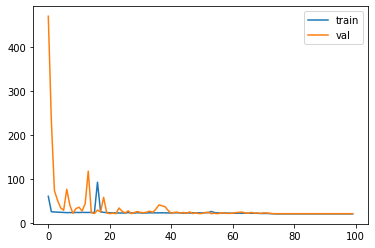

In [12]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

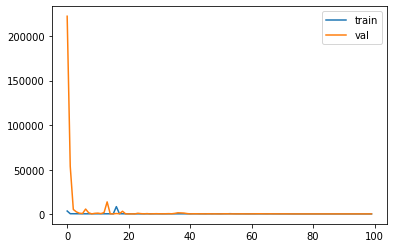

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [14]:
preds = model.predict(test_dataset)

In [15]:
submisson_df = test_df[['Id']]
submisson_df['Pawpularity'] = preds

In [16]:
submisson_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,38.13047
1,43a2262d7738e3d420d453815151079e,38.13047
2,4e429cead1848a298432a0acad014c9d,38.13047
3,80bc3ccafcc51b66303c2c263aa38486,38.13047
4,8f49844c382931444e68dffbe20228f4,38.13047
5,b03f7041962238a7c9d6537e22f9b017,38.13047
6,c978013571258ed6d4637f6e8cc9d6a3,38.13047
7,e0de453c1bffc20c22b072b34b54e50f,38.13047


In [17]:
submisson_df.to_csv('submission.csv', index=False)

In [18]:
model.save('/kaggle/working/multi_vanilla_model.h5')